In [2]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import time
import pickle
import rustworkx as rx

In [3]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [4]:
plt.rcParams.update({"font.size": 14})
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [5]:
def expected_nodes(r0):
    return 4 * r0**3 + 6 * r0**2 + 3 * r0 + 1

def dual_plot(cluster, strength, r_list, sig_vals, filename=None):
    fig, ax1 = plt.subplots()
    # ax1.set_yscale("log")
    max_density_sigma = 0
    max_density = 0
    color = "tab:blue"
    ax1.set_xlabel(r"Bond Acceptance Probability $p$")
    ax1.set_ylabel("Average Cluster Size", color=color)
    for idx, r in enumerate(r_list):
        ax1.scatter(
            sig_vals,
            cluster[r],
            label=f"N={expected_nodes(r)}",
            color=color,
            alpha=(idx + 1) / len(r_list),
        )
        ax1.tick_params(axis="y", labelcolor=color)
        if max_density < np.max(cluster[r]):
            max_density_sigma = sig_vals[np.argmax(cluster[r])]
            max_density = np.max(cluster[r])

    ax1.axvline(x=max_density_sigma, color="black", linestyle="--")
    plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.75))

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = "tab:red"
    ax2.set_ylabel(
        "Percolation Strength", color=color
    )  # we already handled the x-label with ax1
    for idx, r in enumerate(r_list):
        ax2.scatter(
            sig_vals,
            strength[r],
            label=f"N={expected_nodes(r)}",
            color=color,
            alpha=(idx + 1) / len(r_list),
        )
        ax2.tick_params(axis="y", labelcolor=color)

    plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.25))
    if filename is not None:
        plt.savefig(filename + ".pdf", format="pdf", dpi=900, bbox_inches="tight")
        plt.savefig(filename + ".png", format="png", dpi=900, bbox_inches="tight")
    plt.show()

In [6]:
r_list = [8, 10, 12, 14]
p_vals = np.arange(0, .5, 0.01)
reps = 100
density = {}
strength = {}


nn_cluster = {}
nn_strength = {}
fcc = nmr.FccGraph()
calc = nmr.ClassicalGraph(fcc)
for r in r_list:
    start = time.time()
    nn_cluster[r] = [
        calc.avg_cluster_size(p=p, dim=r, layers=1, repititions=reps)
        for p in p_vals
    ]
    nn_strength[r] = [
        calc.percolation_strength(p=p, dim=r, layers=1, repititions=reps)
        for p in p_vals
    ]
    end = time.time()
    print(
        f"Avg Computation time per fcc graph for r={r} is {(end-start)/(reps*len(p_vals))} s"
    )

Avg Computation time per fcc graph for r=8 is 0.01510334701538086 s
Avg Computation time per fcc graph for r=10 is 0.030557711124420166 s
Avg Computation time per fcc graph for r=12 is 0.05414113869667053 s
Avg Computation time per fcc graph for r=14 is 0.08738663773536683 s


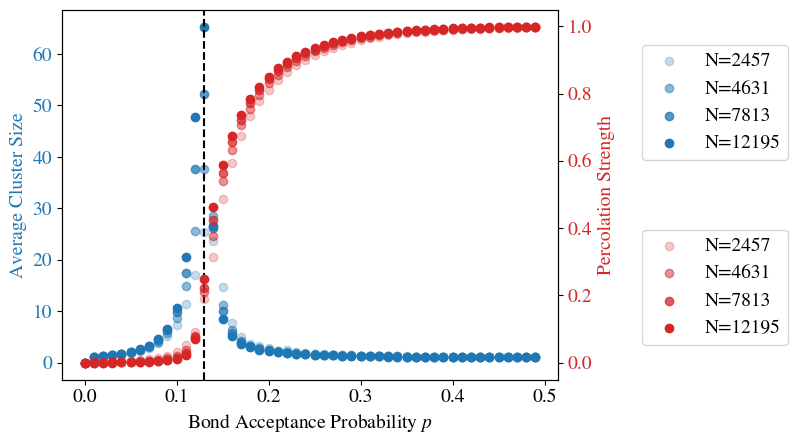

In [7]:
# this shows phase transition at p~0.13 or so
dual_plot(nn_cluster, nn_strength, r_list, p_vals, "numerical_perc_nn_classical")

In [7]:
# Find the p_val at which the average cluster size is maximized for each r in r_list
max_indices = {r: np.argmax(nn_cluster[r]) for r in r_list}
max_p_vals = {r: p_vals[max_indices[r]] for r in r_list}
max_p_vals

NameError: name 'r_list' is not defined

In [11]:
fcc = nmr.FccGraph()
vecs = fcc._fcc_dipole_adj(1)[0][1]
neighbors = len(vecs)

def rand_hop():
    """Generate a random hop based on the FCC lattice vectors."""
    return vecs[np.random.randint(neighbors)]


In [12]:
r0 = np.array([0, 0, 0])

In [13]:
steps = 500
walkers = 25000
displacement = np.zeros((walkers,steps+1))
survival = np.zeros(steps+1)
survival[0] = 1

for k in range(walkers):
    r0 = np.array([0, 0, 0])
    for idx in range(steps):
        r0 += rand_hop()
        displacement[k,idx+1] = np.linalg.norm(r0)
        if np.all(r0 == np.array([0, 0, 0])):
            survival[idx+1] += 1/walkers

KeyboardInterrupt: 

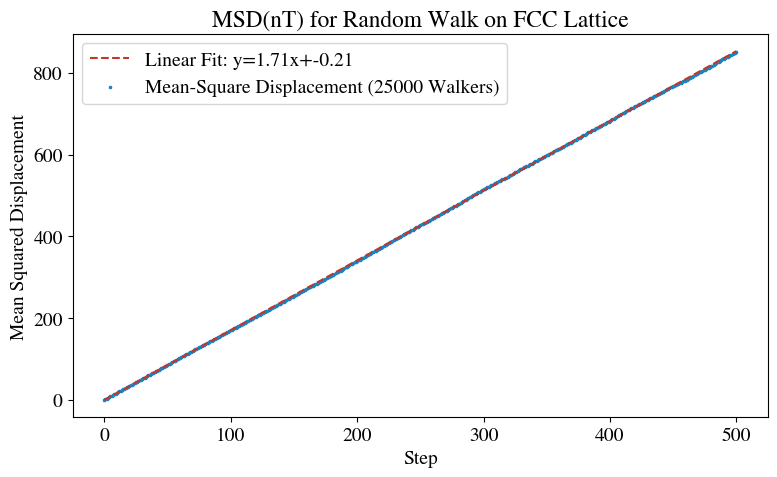

In [104]:
avg_distances = np.mean(displacement, axis=0)
msd = avg_distances**2


plt.figure(figsize=(8, 5))
# Fit the MSD to a line (y = a*x + b)
x = np.arange(steps + 1)
fit = np.polyfit(x, msd, 1)
fit_fn = np.poly1d(fit)
plt.plot(x, fit_fn(x), color=colors[-1], label=f"Linear Fit: y={fit[0]:.2f}x+{fit[1]:.2f}",linestyle='--')
plt.scatter(x,msd, color=colors[0], label="Mean-Square Displacement (25000 Walkers)", marker='x', s=3)
plt.xlabel("Step")
plt.ylabel("Mean Squared Displacement")
plt.title("MSD(nT) for Random Walk on FCC Lattice")
plt.legend()
plt.tight_layout()
plt.show()

Power law exponent (slope): 0.9970
Intercept: 0.5505


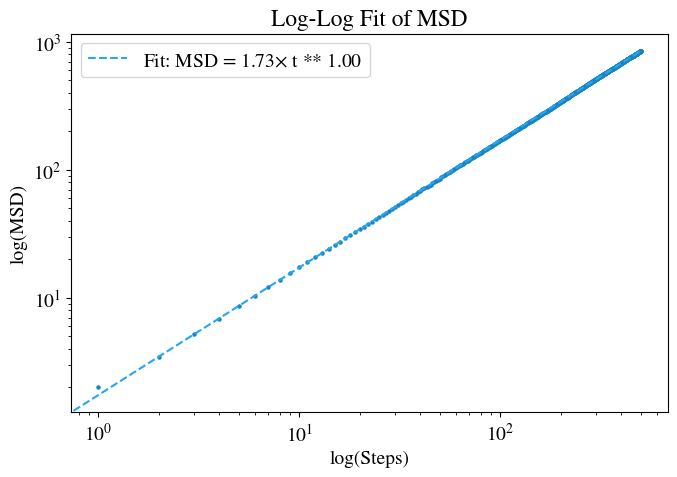

In [102]:
# Perform a linear fit in log-log space to extract the power law exponent
log_x = np.log(x[1:])  # skip x=0 to avoid log(0)
log_msd = np.log(msd[1:])  # skip msd[0]=0

slope, intercept = np.polyfit(log_x, log_msd, 1)
power_law_fn = np.poly1d([slope, intercept])

print(f"Power law exponent (slope): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")

# Optional: plot the log-log fit
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
plt.plot(x, np.exp(intercept)*x**slope, color=colors[1], linestyle='--', label=rf'Fit: MSD = {np.exp(intercept):.2f}$\times$ t ** {slope:.2f}')
plt.scatter(x, msd, color=colors[0], s=5)
plt.xlabel('log(Steps)')
plt.ylabel('log(MSD)')
plt.title('Log-Log Fit of MSD')
plt.legend()
plt.tight_layout()
plt.show()

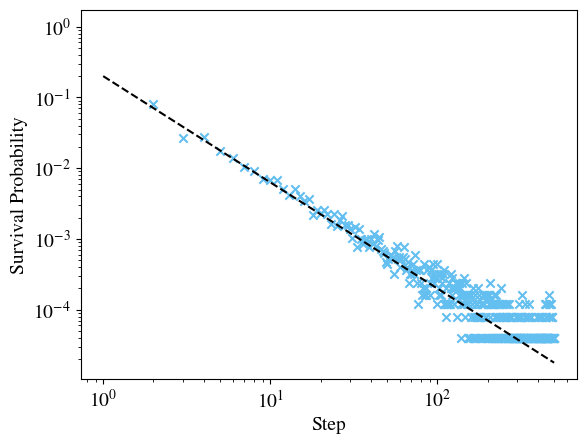

In [107]:
plt.scatter(x, survival, color=colors[2], label="Survival Probability, 25000 Walkers", marker='x')
plt.plot(x[1:], 0.2*x[1:]**(-3/2), color='black', linestyle='--')
plt.xlabel("Step")
plt.ylabel("Survival Probability")
plt.xscale('log')
plt.yscale('log')
plt.show()

In [14]:
def rand_hop_disorder(p=1):
    """Generate a random hop based on the FCC lattice vectors."""
    allowed = np.random.rand(neighbors) < p
    idxs = np.where(allowed)[0] 
    return vecs[np.random.choice(idxs)] if len(idxs) > 0 else np.zeros(3,dtype=int)

In [15]:
vecs

[array([-1, -1,  0]),
 array([-1,  1,  0]),
 array([ 1, -1,  0]),
 array([1, 1, 0]),
 array([-1,  0, -1]),
 array([-1,  0,  1]),
 array([ 1,  0, -1]),
 array([1, 0, 1]),
 array([ 0, -1, -1]),
 array([ 0, -1,  1]),
 array([ 0,  1, -1]),
 array([0, 1, 1])]

In [16]:
ord_vecs = [vecs[0], vecs[3], vecs[1],vecs[2], vecs[4], vecs[7], vecs[5], vecs[6], vecs[8], vecs[11],vecs[9], vecs[10]]


In [17]:
from collections import defaultdict

ord_vecs = [vecs[0], vecs[3], vecs[1],vecs[2], vecs[4], vecs[7], vecs[5], vecs[6], vecs[8], vecs[11],vecs[9], vecs[10]]

class DisorderedLattice:
    def __init__(self, vecs, p):
        self.vecs = vecs
        self.p = p
        self.memory = defaultdict(dict)  # memory[pos][direction_index] = True/False
        self.check_ordered()
        
    def check_ordered(self):
        """
        Checks if the vectors are ordered such that each pair of vectors is opposite to each other.
        This is a sanity check to ensure that the vectors are correctly defined for the lattice.
        """
        for idx in range(len(self.vecs)):
            if idx % 2 == 0:
                assert np.all(self.vecs[idx] + self.vecs[idx + 1] == np.zeros(3, dtype=int))
            else:
                assert np.all(self.vecs[idx] + self.vecs[idx - 1] == np.zeros(3, dtype=int))

    def get_bonds(self, pos):
        r"""
        Checks if the site has been initialized in memory, either by visiting it before,
        or visiting its neighbors. If not, it initializes the bonds for this site. It should 
        also partially initialize the bonds for its neighbors, so that we don't regenerate
        the same bonds over and over again.
        Args:
            pos (list or np.array): The position in the lattice as a list or numpy array.
        Returns:
            dict: A dictionary where keys are indices of the lattice vectors and values are booleans
                  indicating whether the bond in that direction is open (True) or closed (False) or 
                  ungenerated (None).
        """
        pos_tuple = tuple(pos)
        if not self.memory[pos_tuple]:
            # this is the first time we have visited a site...
            allowed = np.random.rand(neighbors) < self.p
            for i, is_open in enumerate(allowed):
                self.memory[pos_tuple][i] = is_open
                self.memory[tuple(pos + self.vecs[i])][i+(-1)**i] = is_open
        elif len(self.memory[pos_tuple]) < neighbors:
            # If the position is already initialized but not all bonds are set, we update them
            # this is probably going to run everytime other than the first time we start a walk
            for i in range(neighbors):
                if i not in self.memory[pos_tuple]:
                    is_open = np.random.rand() < self.p
                    self.memory[pos_tuple][i] = is_open
                    self.memory[tuple(pos + self.vecs[i])][i+(-1)**i] = is_open
                    
        return self.memory[pos_tuple]

    def rand_hop(self, pos):
        bonds = self.get_bonds(pos)
        allowed_idxs = [i for i, open_ in bonds.items() if open_]
        if allowed_idxs:
            idx = np.random.choice(allowed_idxs)
            return self.vecs[idx]
        else:
            return np.zeros(3, dtype=int)




In [18]:
def disordered_walk(steps, walkers, p):
    """ 
    Returns the mean squared displacement and survival probability for a disordered walk on an FCC lattice.
    This function simulates a random walk on a disordered FCC lattice, where each step is chosen as a random 
    connected neighbor of the current position. A bonds are generated/cut with probability `p` for each step,
    and stored so that the lattice disorder is quenched. Each walker starts at the origin and regenerates
    their own lattice bonds, so that walkers will sample disordered lattices independently.

    Args:
        steps (int): Number of random walk steps to take.
        walkers (int): Number of walkers to simulate.
        p (float in [0,1]): Bond acceptance probability, where 1 means all bonds are open and 0 means all bonds are closed.

    Returns:
        tuple: A pair of numpy arrays containing the mean squared displacement (msd) and survival probability at each step,
               averaged over all walkers.
    """
    displacement = np.zeros((walkers, steps + 1))
    survival = np.zeros(steps + 1)
    survival[0] = 1

    for k in range(walkers):
        r0 = np.array([0, 0, 0])
        lattice = DisorderedLattice(ord_vecs, p)
        for idx in range(steps):
            r0 += lattice.rand_hop(r0)
            displacement[k, idx + 1] = np.linalg.norm(r0)
            if np.all(r0 == np.array([0, 0, 0])):
                survival[idx + 1] += 1 / walkers

    avg_distances = np.mean(displacement, axis=0)
    msd = avg_distances**2
    return msd, survival

def disordered_walk_path(steps, p):
    """ 
    Returns the mean squared displacement and survival probability for a disordered walk on an FCC lattice.
    This function simulates a random walk on a disordered FCC lattice, where each step is chosen as a random 
    connected neighbor of the current position. A bonds are generated/cut with probability `p` for each step,
    and stored so that the lattice disorder is quenched. Each walker starts at the origin and regenerates
    their own lattice bonds, so that walkers will sample disordered lattices independently.

    Args:
        steps (int): Number of random walk steps to take.
        p (float in [0,1]): Bond acceptance probability, where 1 means all bonds are open and 0 means all bonds are closed.

    Returns:
        array: the path of the random walk as a numpy array of shape (steps + 1, 3), where each row represents the position at each step.
        The first row is always the origin [0, 0, 0].
    """
    path = np.zeros((steps + 1,3))
    r0 = np.array([0, 0, 0])
    lattice = DisorderedLattice(ord_vecs, p)
    for idx in range(steps):
        r0 += lattice.rand_hop(r0)
        path[idx+1, :] = r0

    return path

In [21]:
test = disordered_walk_path(100, 1)

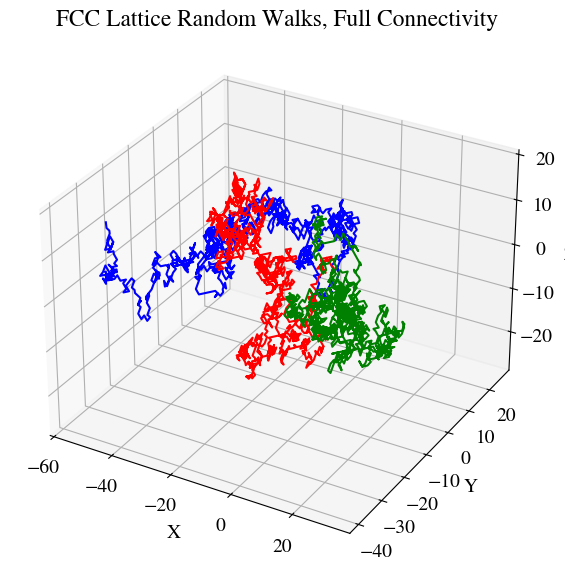

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

steps=1000
p=1

walk1 = disordered_walk_path(steps, p)
walk2 = disordered_walk_path(steps, p)
walk3 = disordered_walk_path(steps, p)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(walk1[:, 0], walk1[:, 1], walk1[:, 2], color="blue")
ax.plot(walk2[:, 0], walk2[:, 1], walk2[:, 2], color="red")
ax.plot(walk3[:, 0], walk3[:, 1], walk3[:, 2], color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('FCC Lattice Random Walks, Full Connectivity')
plt.tight_layout()
plt.show()

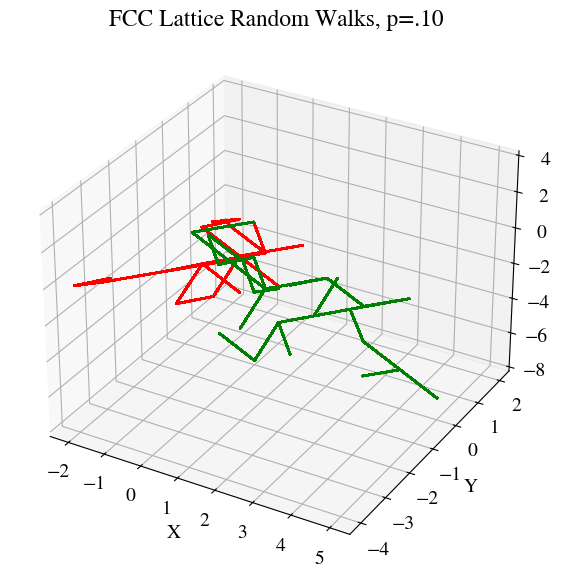

In [65]:
from mpl_toolkits.mplot3d import Axes3D

steps=10000
p=0.10

walk1 = disordered_walk_path(steps, p)
walk2 = disordered_walk_path(steps, p)
walk3 = disordered_walk_path(steps, p)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(walk1[:, 0], walk1[:, 1], walk1[:, 2], color="blue")
ax.plot(walk2[:, 0], walk2[:, 1], walk2[:, 2], color="red")
ax.plot(walk3[:, 0], walk3[:, 1], walk3[:, 2], color="green")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('FCC Lattice Random Walks, p=.10')
plt.tight_layout()
plt.show()

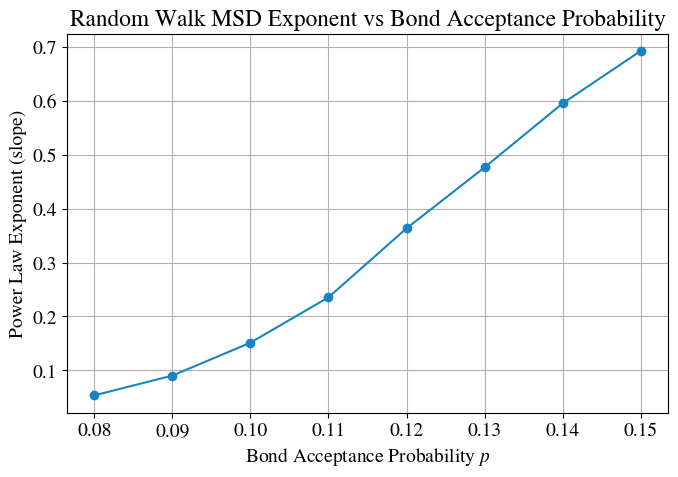

In [138]:
# Compute MSD and survival probability for a range of p values
p_range = np.arange(0.08, 0.16, 0.01)
slopes = []
intercepts = []

for p_val in p_range:
    msd, survival = disordered_walk(steps=1000, walkers=10000, p=p_val)
    # Linear fit in log-log space (skip x=0 to avoid log(0))
    log_x = np.log(np.arange(1, 1001))
    log_msd = np.log(msd[1:])
    slope, intercept = np.polyfit(log_x, log_msd, 1)
    slopes.append(slope)
    intercepts.append(intercept)

plt.figure(figsize=(7, 5))
plt.plot(p_range, slopes, marker='o', color=colors[0])
plt.xlabel('Bond Acceptance Probability $p$')
plt.ylabel('Power Law Exponent (slope)')
plt.title('Random Walk MSD Exponent vs Bond Acceptance Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

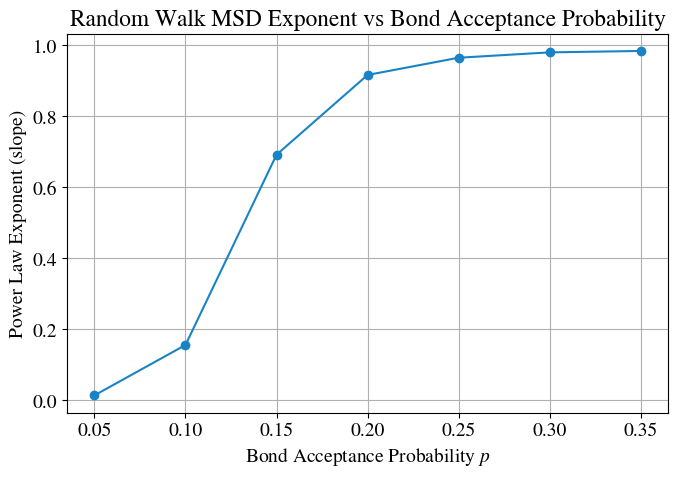

In [139]:
# Compute MSD and survival probability for a range of p values
p_range = np.arange(0.05, 0.4, 0.05)
slopes = []
intercepts = []

for p_val in p_range:
    msd, survival = disordered_walk(steps=1000, walkers=10000, p=p_val)
    # Linear fit in log-log space (skip x=0 to avoid log(0))
    log_x = np.log(np.arange(1, 1001))
    log_msd = np.log(msd[1:])
    slope, intercept = np.polyfit(log_x, log_msd, 1)
    slopes.append(slope)
    intercepts.append(intercept)

plt.figure(figsize=(7, 5))
plt.plot(p_range, slopes, marker='o', color=colors[0])
plt.xlabel('Bond Acceptance Probability $p$')
plt.ylabel('Power Law Exponent (slope)')
plt.title('Random Walk MSD Exponent vs Bond Acceptance Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

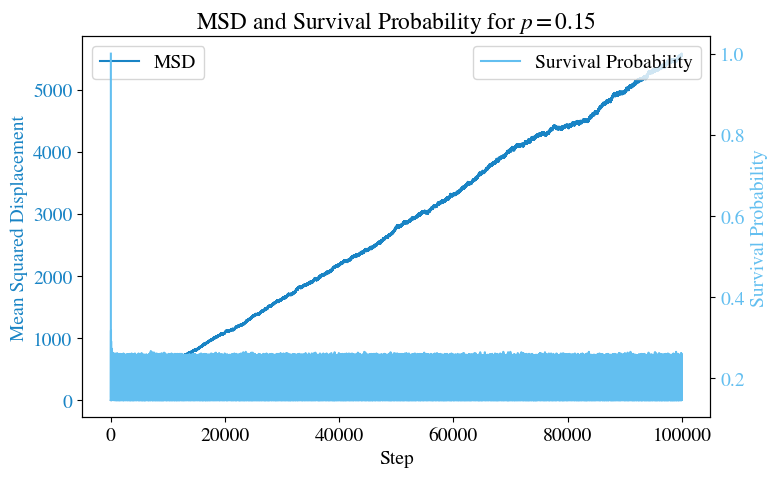

In [129]:
# Simulate disordered walk for p = 0.15
p = 0.15
steps = 100000
walkers = 1000
msd, survival = disordered_walk(steps, walkers, p)
x = np.arange(steps + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))
color = colors[0]
ax1.set_xlabel("Step")
ax1.set_ylabel("Mean Squared Displacement", color=color)
ax1.plot(x, msd, color=color, label="MSD")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = colors[2]
ax2.set_ylabel("Survival Probability", color=color)
ax2.plot(x, survival, color=color, label="Survival Probability")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

plt.title("MSD and Survival Probability for $p=0.15$")
plt.tight_layout()
plt.show()

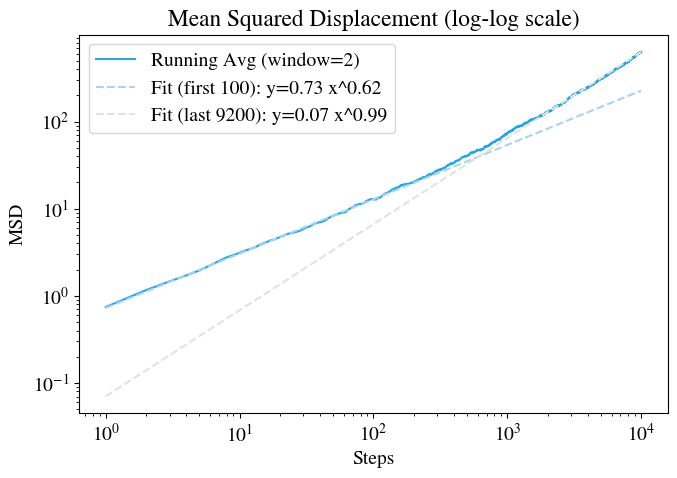

In [ ]:
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
lookback = 2  # set the lookback window size
running_avg = np.convolve(msd, np.ones(lookback)/lookback, mode='valid')
plt.plot(x[lookback-1:], running_avg, color=colors[1], label=f"Running Avg (window={lookback})")
#plt.plot(x, msd, color=colors[0], label="Mean Squared Displacement")

# Perform linear fit in log-log space on the first 100 points of the running average

fit_x = np.log(x[lookback-1:lookback-1+100])
fit_y = np.log(running_avg[:100])
slope, intercept = np.polyfit(fit_x, fit_y, 1)
fit_line = np.exp(intercept) * x[lookback-1:] ** slope

plt.plot(x[lookback-1:], fit_line, color=colors[3], linestyle='--',
         label=f'Fit (first 100): y={np.exp(intercept):.2f} x^{slope:.2f}')


# Perform linear fit in log-log space on the last 500 points of the running average
start = 800
fit_x_last = np.log(x[lookback-1+len(running_avg)-start:lookback-1+len(running_avg)])
fit_y_last = np.log(running_avg[-start:])
slope_last, intercept_last = np.polyfit(fit_x_last, fit_y_last, 1)
fit_line_last = np.exp(intercept_last) * x[lookback-1:] ** slope_last

plt.plot(x[lookback-1:], fit_line_last, color=colors[4], linestyle='--',
            label=f'Fit (last {start}): y={np.exp(intercept_last):.2f} x^{slope_last:.2f}')


plt.xlabel("Steps")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement (log-log scale)")
plt.legend()
plt.tight_layout()
plt.show()




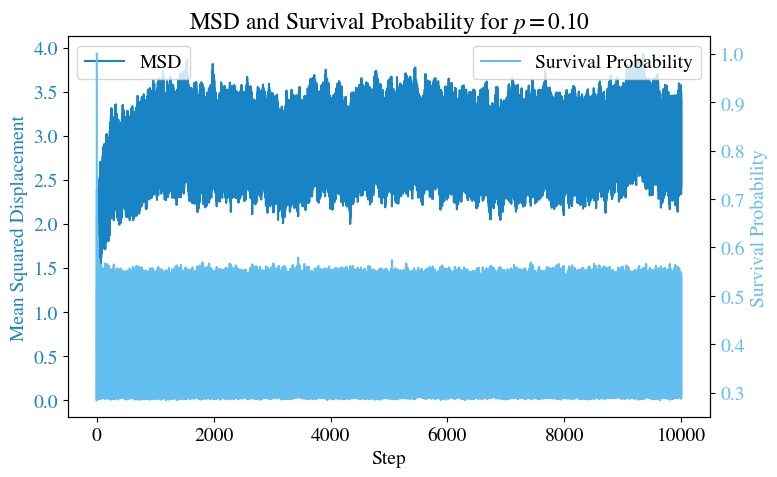

In [15]:
# Simulate disordered walk for p = 0.10
p = 0.10
steps = 10000
walkers = 1000
msd, survival = disordered_walk(steps, walkers, p)
x = np.arange(steps + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))
color = colors[0]
ax1.set_xlabel("Step")
ax1.set_ylabel("Mean Squared Displacement", color=color)
ax1.plot(x, msd, color=color, label="MSD")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = colors[2]
ax2.set_ylabel("Survival Probability", color=color)
ax2.plot(x, survival, color=color, label="Survival Probability")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

plt.title("MSD and Survival Probability for $p=0.10$")
plt.tight_layout()
plt.show()

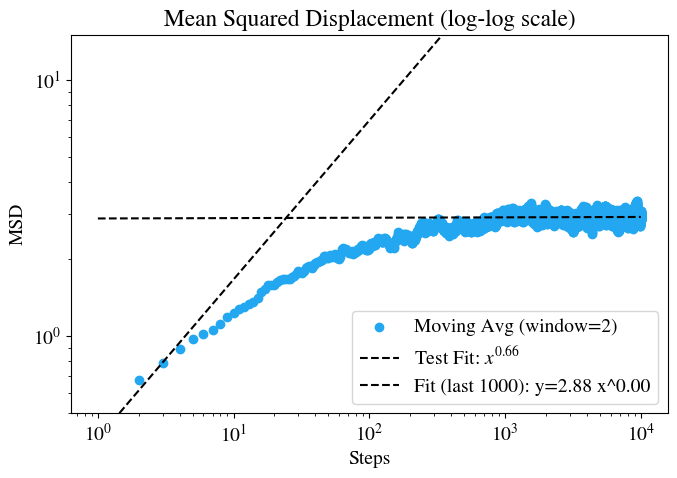

In [60]:
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
#plt.plot(x[1:], msd[1:], color=colors[0], label="MSD (log-log)")
lookback = 2  # you can change this value for different smoothing
msd_smooth = np.convolve(msd[1:], np.ones(lookback)/lookback, mode='valid')
plt.scatter(x[lookback:len(msd)], msd_smooth, color=colors[1], label=f"Moving Avg (window={lookback})")


# Perform linear fit in log-log space on the first 100 points of the running average
end = 2

fit_x = np.log(x[lookback-1:end+1])
fit_y = np.log(msd_smooth[1:end+1])
slope, intercept = np.polyfit(fit_x, fit_y, 1)
fit_line = np.exp(intercept) * x[1:] ** slope

test = .4*x[lookback-1:]**.62
plt.plot(x[1:], test, color="black", linestyle='--', label="Test Fit: $x^{0.66}$")

#plt.plot(x[lookback-1:], fit_line, color=colors[3], linestyle='--',label=f'Fit (first 100): y={np.exp(intercept):.2f} x^{slope:.2f}')


# Perform linear fit in log-log space on the las
start = 9000
fit_x_last = np.log(x[-start:])
fit_y_last = np.log(msd_smooth[-start:])
slope_last, intercept_last = np.polyfit(fit_x_last, fit_y_last, 1)
fit_line_last = np.exp(intercept_last) * x[1:] ** slope_last

plt.plot(x[1:], fit_line_last, color='black', linestyle='--',
            label=f'Fit (last {steps-start}): y={np.exp(intercept_last):.2f} x^{slope_last:.2f}')


plt.xlabel("Steps")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement (log-log scale)")
plt.legend()
plt.tight_layout()
plt.ylim([.5,15])
plt.show()

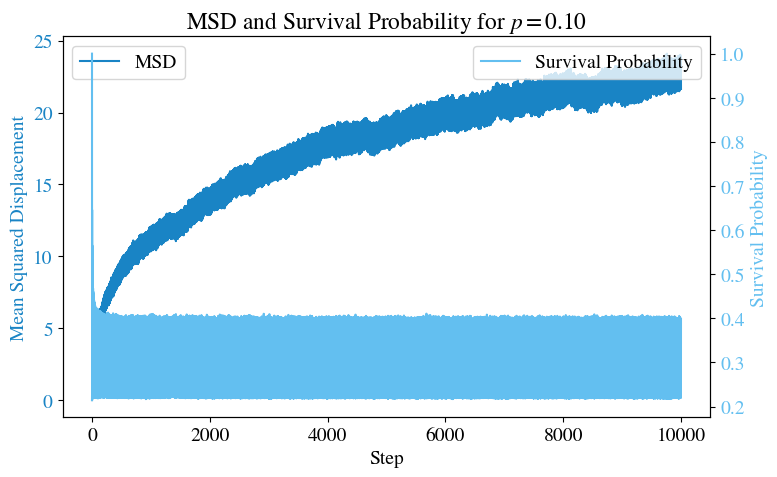

In [ ]:
# Simulate disordered walk for p = 0.12
p = 0.12
steps = 10000
walkers = 5000
msd, survival = disordered_walk(steps, walkers, p)
x = np.arange(steps + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))
color = colors[0]
ax1.set_xlabel("Step")
ax1.set_ylabel("Mean Squared Displacement", color=color)
ax1.plot(x, msd, color=color, label="MSD")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = colors[2]
ax2.set_ylabel("Survival Probability", color=color)
ax2.plot(x, survival, color=color, label="Survival Probability")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

plt.title("MSD and Survival Probability for $p=0.12$")
plt.tight_layout()
plt.show()

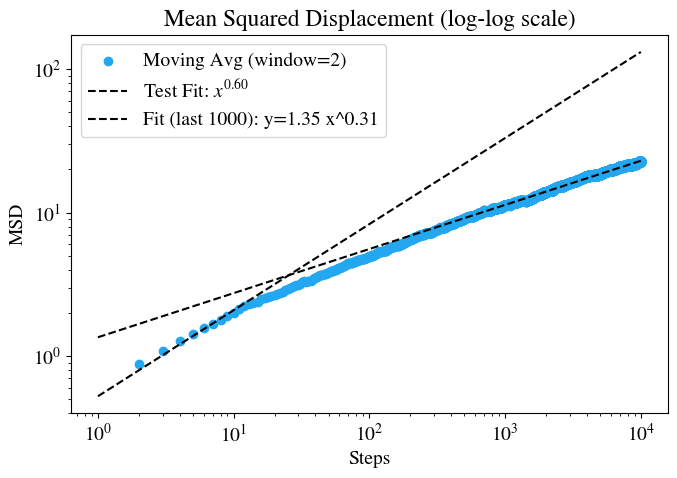

In [68]:
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
#plt.plot(x[1:], msd[1:], color=colors[0], label="MSD (log-log)")
lookback = 2  # you can change this value for different smoothing
msd_smooth = np.convolve(msd[1:], np.ones(lookback)/lookback, mode='valid')
plt.scatter(x[lookback:len(msd)], msd_smooth, color=colors[1], label=f"Moving Avg (window={lookback})")


# Perform linear fit in log-log space on the first 100 points of the running average
end = 2

fit_x = np.log(x[lookback-1:end+1])
fit_y = np.log(msd_smooth[1:end+1])
slope, intercept = np.polyfit(fit_x, fit_y, 1)
fit_line = np.exp(intercept) * x[1:] ** slope

test = .525*x[lookback-1:]**.6
plt.plot(x[1:], test, color="black", linestyle='--', label="Test Fit: $x^{0.60}$")

#plt.plot(x[lookback-1:], fit_line, color=colors[3], linestyle='--',label=f'Fit (first 100): y={np.exp(intercept):.2f} x^{slope:.2f}')


# Perform linear fit in log-log space on the las
start = 9000
fit_x_last = np.log(x[-start:])
fit_y_last = np.log(msd_smooth[-start:])
slope_last, intercept_last = np.polyfit(fit_x_last, fit_y_last, 1)
fit_line_last = np.exp(intercept_last) * x[1:] ** slope_last

plt.plot(x[1:], fit_line_last, color='black', linestyle='--',
            label=f'Fit (last {steps-start}): y={np.exp(intercept_last):.2f} x^{slope_last:.2f}')


plt.xlabel("Steps")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement (log-log scale)")
plt.legend()
plt.tight_layout()
plt.ylim()
plt.show()

In [8]:
2/(2+1.55)

0.5633802816901409

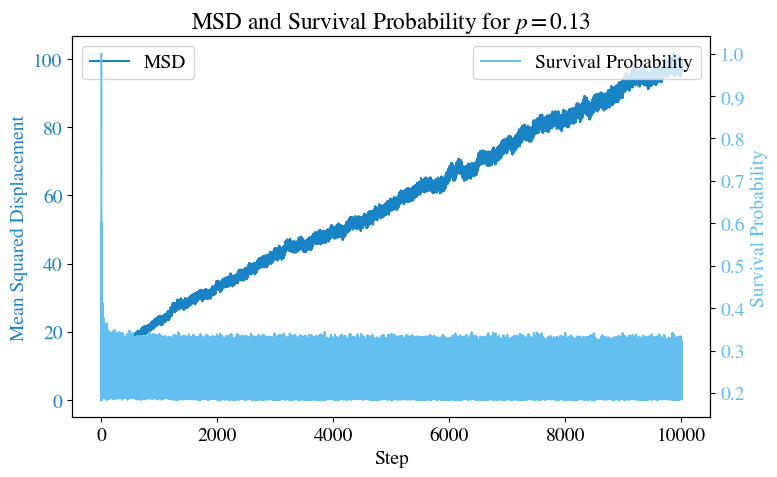

In [70]:
# Simulate disordered walk for p = 0.13
p = 0.13
steps = 10000
walkers = 1000
msd, survival = disordered_walk(steps, walkers, p)
x = np.arange(steps + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))
color = colors[0]
ax1.set_xlabel("Step")
ax1.set_ylabel("Mean Squared Displacement", color=color)
ax1.plot(x, msd, color=color, label="MSD")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = colors[2]
ax2.set_ylabel("Survival Probability", color=color)
ax2.plot(x, survival, color=color, label="Survival Probability")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

plt.title("MSD and Survival Probability for $p=0.13$")
plt.tight_layout()
plt.show()

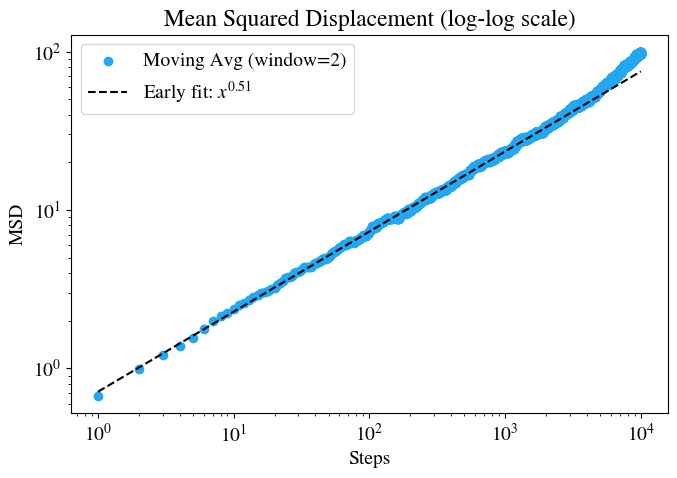

In [104]:
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
lookback = 2  # you can change this value for different smoothing
msd_smooth = np.convolve(msd, np.ones(lookback)/lookback, mode='valid')
plt.scatter(x[lookback-1:], msd_smooth, color=colors[1], label=f"Moving Avg (window={lookback})")


# Linear fit in log-log space for the first `end` points (early)
end=2000
fit_x_early = np.log(x[lookback-1:end+lookback-1])
fit_y_early = np.log(msd_smooth[:end])
slope_early, intercept_early = np.polyfit(fit_x_early, fit_y_early, 1)
fit_line_early = np.exp(intercept_early) * x[lookback-1:] ** slope_early
plt.plot(x[lookback-1:], fit_line_early, 'k--', label=f'Early fit: $x^{{{slope_early:.2f}}}$')



plt.xlabel("Steps")
plt.ylabel("MSD")
plt.title("Mean Squared Displacement (log-log scale)")
plt.legend()
plt.tight_layout()
plt.show()

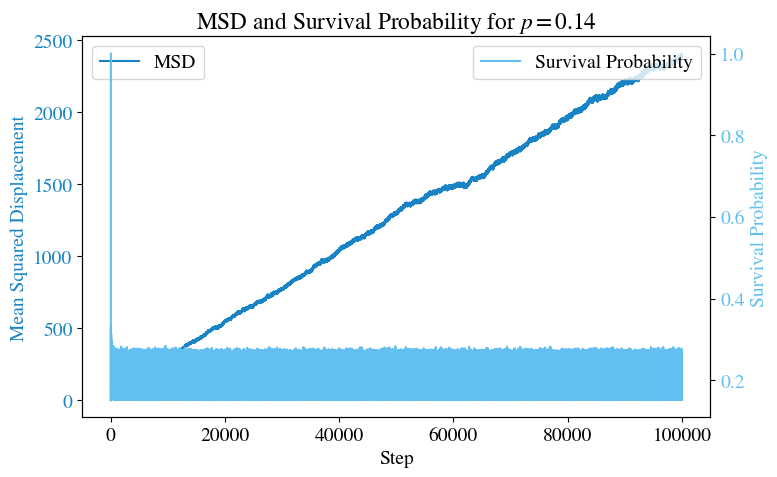

In [105]:
# Simulate disordered walk for p = 0.14
p = 0.14
steps = 100000
walkers = 1000
msd, survival = disordered_walk(steps, walkers, p)
x = np.arange(steps + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))
color = colors[0]
ax1.set_xlabel("Step")
ax1.set_ylabel("Mean Squared Displacement", color=color)
ax1.plot(x, msd, color=color, label="MSD")
ax1.tick_params(axis="y", labelcolor=color)
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
color = colors[2]
ax2.set_ylabel("Survival Probability", color=color)
ax2.plot(x, survival, color=color, label="Survival Probability")
ax2.tick_params(axis="y", labelcolor=color)
ax2.legend(loc="upper right")

plt.title("MSD and Survival Probability for $p=0.14$")
plt.tight_layout()
plt.show()

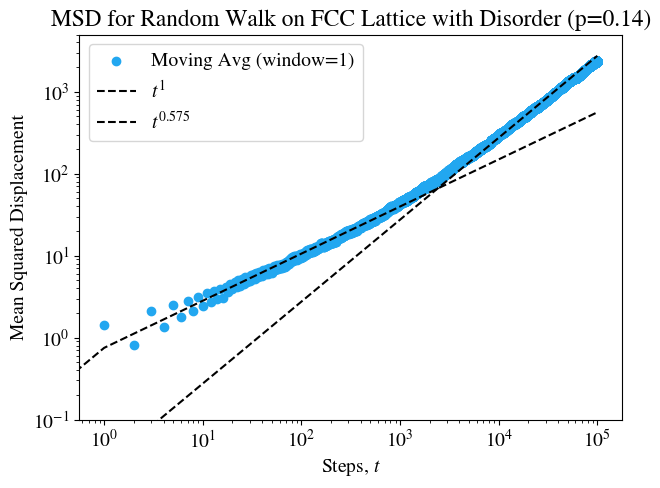

In [128]:
plt.figure(figsize=(7, 5))
plt.xscale('log')
plt.yscale('log')
lookback = 1  # you can change this value for different smoothing
msd_smooth = np.convolve(msd, np.ones(lookback)/lookback, mode='valid')
plt.scatter(x[lookback-1:], msd_smooth, color=colors[1], label=f"Moving Avg (window={lookback})")
plt.plot(x, .0275*x**1, color="black", linestyle='--', label="$t^{1}$")
plt.plot(x, .75*x**.575, color="black", linestyle='--', label="$t^{0.575}$")
plt.ylim([.1,5e3])
plt.legend()
plt.xlabel(r"Steps, $t$")
plt.ylabel("Mean Squared Displacement")
plt.title("MSD for Random Walk on FCC Lattice with Disorder (p=0.14)")
plt.show()